# Host Comm

In [9]:
# %%writefile "/home/pi/iot49/host_comm.py"
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

def live_plot(fs, i_state, f_state):
    clear_output(wait=True)
    plt.figure(figsize=(10, 8))
    t = i_state[:,_ISTATE_K] / fs
    y = i_state[:,_ISTATE_ENC1]
    print("lp", t, y)
    plt.plot(t, y)
    plt.show()


import time

def reset_mcu():
    # no generic PIN in gpizero?
    from gpiozero import LED
    with LED(21) as nrst:
        nrst.off()
        time.sleep(0.1)
        nrst.on()
        time.sleep(0.5)
        
def rsync_mcu():
    from iot_device import DeviceRegistry
    dev = 'serial:///dev/serial0'
    registry = DeviceRegistry()
    registry.register(dev)
    with registry.get_device(dev) as repl:
        repl.rsync(lambda x: print(x), dry_run=False)

def exec_mcu(cmd):
    from iot_device import DeviceRegistry
    dev = 'serial:///dev/serial0'
    registry = DeviceRegistry()
    registry.register(dev)
    with registry.get_device(dev) as repl:
        res = repl.exec(cmd)
        try:
            res = res.decode()
        except:
            pass
        return res
    
def exec_mcu_no_follow(cmd):
    from serial import Serial
    with Serial('/dev/serial0', 115200, timeout=0.5, write_timeout=2, exclusive= True) as serial:
        pyb = Pydevice(serial)
        pyb.enter_raw_repl()
        pyb.exec_raw_no_follow(cmd)
        time.sleep(0.2)
        while serial.in_waiting:
            data = serial.read(serial.in_waiting)
            try:
                data = data.decode()
            except:
                pass
            print(f"*** MCU: {data}")
            time.sleep(0.1)
        
        
        
import nest_asyncio
nest_asyncio.apply()

from iot_device.pydevice import Pydevice
from serial import Serial
from array import array
from struct import pack, unpack
import numpy as np
import asyncio, time

def const(x): return bytes([x])

_CMD_STATE            = const(10)
_CMD_MSG              = const(11)
_CMD_SET              = const(12)
_CMD_GET              = const(13)
_CMD_STATE_SIZE       = const(14)
_CMD_START_CONTROLLER = const(15)
_CMD_STOP_CONTROLLER  = const(16)
_CMD_SHUTDOWN         = const(17)
_CMD_GC_FREE          = const(18)
_CMD_GC_COLLECT       = const(19)
_CMD_ECHO             = const(20)


def const(x): return x

_ISTATE_K       = const(0)
_ISTATE_DT1     = const(1)
_ISTATE_DT2     = const(2)
_ISTATE_ENC1    = const(3)
_ISTATE_ENC2    = const(4)
ISTATE_SIZE = 5

_FSTATE_VEL1    = const(0)
_FSTATE_VEL2    = const(1)
_FSTATE_VEL1_SP = const(2)
_FSTATE_VEL2_SP = const(3)
_FSTATE_DUTY1   = const(4)
_FSTATE_DUTY2   = const(5)
FSTATE_SIZE = 6


class UART:
    
    def __init__(self, **args):
        self._lock = asyncio.Lock()
        self._serial = Serial(**args)

    async def __aenter__(self):
        await self._lock.acquire()
        
        class _UART:
            
            def __init__(self, serial):
                self._serial = serial
                
            async def read(self, sz):
                while self.in_waiting < sz:
                    await asyncio.sleep(0.005)
                return self._serial.read(sz)

            def write(self, data):
                return self._serial.write(data) 
            
            def close(self):
                self._serial.close()
                
            @property
            def in_waiting(self):
                return self._serial.in_waiting
            
        return _UART(self._serial)

    async def __aexit__(self, *args):
        self._lock.release()
        
    @property
    def in_waiting(self):
        return self._serial.in_waiting
    
    @property
    def locked(self):
        return self._lock.locked()


class RobotComm:
    
    def __init__(self):
        self.baudrate = 1000000
        self.fs       = 2
        self.pwm_freq = 10000
        self.state_history = 10
        
    async def __aenter__(self):
        # start program on MCU
        exec_mcu_no_follow(
            f"from comm import Comm\n"
            f"Comm({self.baudrate}, {self.pwm_freq})\n"
        )
        self.uart = UART(port='/dev/serial0', baudrate=self.baudrate, 
                         timeout=2, write_timeout=1, exclusive= True)
        await asyncio.sleep(1)
        await self.init_state_matrices()
        return self
    
    async def __aexit__(self, *args):
        async with self.uart as u:
            u.write(_CMD_SHUTDOWN)
            u.close()
            
    async def cmd_processor(self):
        """Process commands initiated by MCU"""
        while True:
            # we check without having a lock - to not block the uart
            if self.uart.in_waiting:
                async with self.uart as u:
                    # protect against another thread reading first
                    if self.uart.in_waiting:
                        await self.cmd_process(u, await u.read(1))
            else:
                await asyncio.sleep(0.1)
        
    async def cmd_process(self, uart, t):
        if t == _CMD_MSG:
            size = unpack('H', await uart.read(2))[0]
            print(f"> {(await uart.read(size)).decode()}")
        elif t == _CMD_STATE:
            i_state = self.i_state
            iv = np.frombuffer(await uart.read(4*i_state.shape[1]), dtype=np.int32)
            self.i_state = np.r_[ i_state[1:], iv.reshape(1, i_state.shape[1])]
            
            f_state = self.f_state
            fv = np.frombuffer(await uart.read(4*f_state.shape[1]), dtype=np.float32)
            self.f_state = np.r_[ f_state[1:], fv.reshape(1, f_state.shape[1])]

            print("live_plot ...")
            live_plot(self.fs, i_state, f_state)
            print("lp RETURNS")

        else:
            print(f"*** unknown type: {t}")
            # purge uart
            while uart.in_waiting:
                data = await uart.read(uart.in_waiting)
                try:
                    data = data.decode()
                except:
                    pass
                print(data)
                await asyncio.sleep(0.1)
            
    async def cmd_wait_for(self, uart, cmd_t):
        # handle commands until one of the indicated type arrives
        while True:
            t = await uart.read(1)
            if t != cmd_t:
                await self.cmd_process(uart, t)
            else:
                return
            
    async def cmd_get(self, index):
        async with self.uart as u:
            u.write(_CMD_GET)
            u.write(bytes([index]))
            await self.cmd_wait_for(u, _CMD_GET)
            return unpack('f', await u.read(4))
        
    async def cmd_set(self, index, value):
        async with self.uart as u:
            u.write(_CMD_SET)
            u.write(bytes([index]))
            u.write(pack('f', value))
        
    async def init_state_matrices(self):
        # get state column size from MCU and initialize matrices
        async with self.uart as u:
            u.write(_CMD_STATE_SIZE)           
            await self.cmd_wait_for(u, _CMD_STATE_SIZE)
            i_sz, f_sz = unpack('2I', await u.read(8))
            self.i_state = np.empty((self.state_history, i_sz), dtype=np.int32)
            self.f_state = np.empty((self.state_history, f_sz), dtype=np.float32)
            self.i_state[:] = 0
            self.f_state[:] = np.NaN
            self.f_state[:] = 0
            
    async def cmd_start_controller(self, fs, name):
        async with self.uart as u:
            if isinstance(name, str): name = name.encode()
            u.write(_CMD_START_CONTROLLER)
            u.write(pack('2I', fs, len(name)))
            u.write(name)
            
    async def cmd_stop_controller(self):
        async with self.uart as u:
            u.write(_CMD_STOP_CONTROLLER)
            
    async def cmd_gc_free(self):
        async with self.uart as u:
            u.write(_CMD_GC_FREE)
            await self.cmd_wait_for(u, _CMD_GC_FREE)
            return unpack('2I', await u.read(8))
    
    async def cmd_gc_collect(self):
        async with self.uart as u:
            u.write(_CMD_GC_COLLECT)
                   
    async def cmd_echo(self, msg):
        async with self.uart as u:
            u.write(_CMD_ECHO)
            u.write(pack('I', len(msg)))
            u.write(msg)
            await self.cmd_wait_for(u, _CMD_ECHO)
            sz = unpack('I', await u.read(4))[0]
            return await u.read(sz)
    
def exception_handler(loop, context):
    print("***** asyncio:", context)
                                         
async def test_echo(rc):
    import os
    for data in [ b'abcdefg', b'\x00\x01\x02\x04\x05', os.urandom(64), os.urandom(256) ]:
        resp = await rc.cmd_echo(data)
        if data != resp:
            print(f"echo: sent {data}\n      got  {resp}")
            return
    print("test_echo SUCCESS!")
    
async def test_set_get(rc):
    v = 5.3
    await rc.cmd_set(FSTATE_VEL1, v)
    print("get", (await rc.cmd_get(FSTATE_VEL1))[0], "=?=", v)
        
async def main():
    async with RobotComm() as rc:
        asyncio.get_event_loop().set_exception_handler(exception_handler)
        cmd_task = asyncio.create_task(rc.cmd_processor())
        try:
            print("gc:", await rc.cmd_gc_free())
            await rc.cmd_gc_collect()
            print("gc:", await rc.cmd_gc_free())
            print("starting controller")
            await rc.cmd_start_controller(50, "duty_control")
            print("controller running")
            await rc.cmd_set(_FSTATE_DUTY1, 20)
            await rc.cmd_set(_FSTATE_DUTY2, 80)
            await asyncio.sleep(4)
            await rc.cmd_set(_FSTATE_DUTY1, 40)
            await rc.cmd_set(_FSTATE_DUTY2, 60)
            await asyncio.sleep(0.2)
            await rc.cmd_set(_FSTATE_DUTY1, 60)
            await rc.cmd_set(_FSTATE_DUTY2, 40)
            await asyncio.sleep(0.2)
            print("stop controller")
            await rc.cmd_stop_controller()
            print("controller stopped")
            # wait for any final communication from mcu
            await asyncio.sleep(1)
            if False:
                print("i_state")
                print(rc.i_state)
                print("f_state")
                print(rc.f_state)
        finally:
            cmd_task.cancel()

print("reset mcu & rsync")
reset_mcu()
rsync_mcu()
reset_mcu()

print("run main")
asyncio.run(main())

print("Done")

lp [16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21. ] [-502 -518 -535 -551 -568 -584 -601 -618 -634 -651]


KeyboardInterrupt: 

stop controller
controller stopped


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

def live_plot(fs, i_state, f_state, cols, legend):
    clear_output(wait=True)
    plt.figure(figsize=(10, 8))
    t = i_state[_ISTATE_K] / fs
    y = i_state[_ISTATE_ENC1]
    plt.plot(t, y)
    plt.show()


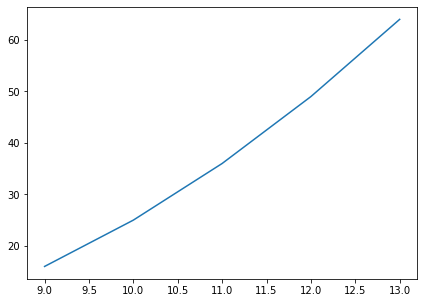

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

N = 5

t = np.arange(N)
y = np.empty(N)
y[:] = np.NaN

def shift(t_, y_):
    global t, y
    t[:N-1] = t[1:]
    t[N-1] = t_
    y[:N-1] = y[1:]
    y[N-1] = y_

def live_plot(t, y):
    clear_output(wait=True)
    plt.figure(figsize=(7,5))
    # print(t, y)
    plt.plot(t, y)
    plt.show()
    
for i in range(10):
    live_plot(t, y)
    shift(i+N, i**2)

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections

%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();
    
data = collections.defaultdict(list)
for i in range(100):
    data['foo'].append(np.random.random())
    data['bar'].append(np.random.random())
    data['baz'].append(np.random.random())
    live_plot(data)

In [32]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections

%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();
    
data = collections.defaultdict(list)
for i in range(100):
    data['foo'].append(np.random.random())
    data['bar'].append(np.random.random())
    data['baz'].append(np.random.random())
    live_plot(data)

0.5778940648596138

TypeError: float() argument must be a string or a number, not 'dict'

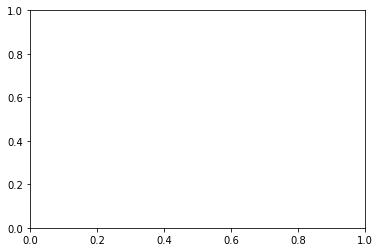

In [34]:
from matplotlib import pyplot as plt

%matplotlib inline

a = np.arange(10)
b = -np.arange(10)

data = {
    'a': a,
    'b': b,
}

plt.plot(data)